### Step 1:Rectification 

In the rectification phase, it uses canny edge detection and then finds (small) lines using probabilstic hough transform as edgelets.Our approach has four stages 

#### Edgelet Computation
An edgelet is an abstract entity, attached to each edge point of the image, with 3 properties: (i) edge location (the image
coordinates of the edge point) (ii) edge direction (unit vector along the edge) (iii) edge strength To compute edgelets, we
run a Harris corner detector style operator on the image. We use a 3 x 3 window to compute derivatives. Eigenvalues
and eigenvectors of the Gaussian weighted covariance matrix corresponding to rectangular 5 x 5 neighborhood around each
pixel are computed. Edgelets are extracted from only those points where one eigen value is big and the other small - these
are the the pure edge points

#### Vanishing Point Estimation

Our vanishing point detector is RANSAC based. Generally speaking, in RANSAC, one hypothesizes a random model and computes consensus for that model by gathering votes for the model. The model with the maximum number of votes wins.

##### RANSAC Model
RANSAC vanishing point detector, a model comprises of a pair of randomly selected edgelets (henceforth referred to as model edgelets). The hypothesis vanishing point corresponding to the model is the point of intersection of the the edgelet lines corresponding to the two model edgelets Thus, given a model <i> M(E1, E2) </i>  comprising of edgelets
$$E_{1}(x^{\rightarrow}_{1},d^{\rightarrow}_{1},s_{1})$$ 
$$E_{2}(x^{\rightarrow}_{2},d^{\rightarrow}_{2},s_{2})$$

the hypothesis vanishing point
$$v^{\rightarrow}_{M} = I^{\rightarrow}_{E1} x I^{\rightarrow}_{E2}$$
is the intersection point of the edgelet lines $I^{\rightarrow}_{E1}$ and $I^{\rightarrow}_{E2}$ 2 (in Homogenous mathematics, cross-products of homogenous vectors corresponding to lines yield their intersection point in homogenous coordinates).

##### RANSAC Consensus Building (voting)
Given model $M(E1, E2)$ , we iterate over all the other edgelets $E_{i}(x^{\rightarrow}_{i},d^{\rightarrow}_{i},s_{i})$. Each $E_{i}$ casts a vote for the model $M$

\begin{equation}
  vote(E_{i},M(E_{1},E_{2})) =
    \begin{cases}
      \frac{1-e^{-\lambda cos^{2} \theta})}{1-e^{-\lambda}} & if \; \theta \leq 5^{\circ} \\
      0 & \text{otherwise}
    \end{cases}       
\end{equation}

where $\theta$ is the smaller angle between the voting edgelet line $l^{\rightarrow}_{E_{i}}$ and the line joining that edgelet’s location $x^{\rightarrow}_{i}$ to the hypothesis vanishing point $v^{\rightarrow}_{M}$. $\lambda$ is a system parameter.

##### Re-estimation of Vanishing Point from best model inliers
Once the consensus gathering phase is over and we have identified the best model, we re-estimate the vanishing point more
accurately via a weighted least squares regression. We estimate the optimal (in a least square sense) intersection point
for all the inlier edgelet lines corresponding to the best model. Let 

$$
  S = \{E_{i} \;|\; vote(E_{i},M_{best}) > 0\} 
$$

denote the set of inlier edgelets corresponding to the best model $M_{best}$ And, let $v^{\rightarrow}_{M}$ denote the (as yet undetermined) optimal vanishing point. Overall, we end up with the overdetermined homogeneous linear system

$$
  Diag(w_{1},w_{2}...w_{N})
\begin{bmatrix} 
a_{1} & b_{1} & c_{1} \\
a_{2} & b_{2} & c_{2}\\
... \\
a_{N} & b_{N} & c_{N} \\
\end{bmatrix}
\begin{bmatrix} 
x^{*}_{M}\\
y^{*}_{M}\\
z^{*}_{M} \\
\end{bmatrix}
= 0
$$

which is homogeneous linear system that we solve for $v^{\rightarrow *}_{M}$ = 
$
\begin{bmatrix} 
x^{*}_{M} & y^{*}_{M} & z^{*}_{M}\\
\end{bmatrix}^{T}
$ via the well known <i>Singular Value Decomposition</i> technique

##### Estimation of the second Vanishing Point:
Once the first vanishing point is estimated, we delete all its inlier edgelets from the edgelets array and repeat the process outlined above to estimate the second vanishing point

#### Computation of Rectification Homography

##### Restoring parallel lines:
In $\mathbb{P}^{2}$ 2, the space of Homogenous 2D points, the Line at Infinity stands for the line containing all the points at infinity, i.e., all points of the form 
$$P^{\rightarrow}_{\infty}$
\begin{bmatrix} 
x & y& 0
\end{bmatrix}^{T}
$$
. Homogenous representation of the line at infinity is 
$$l^{\rightarrow}_{\infty}$
\begin{bmatrix} 
x & y& 0
\end{bmatrix}^{T}
$$

It is easy to verify that $P^{\rightarrow}_{\infty}.l^{\rightarrow}_{\infty} = 0$, which proves that all points on infinity lie on the line at infinity. Geometrically speaking, an image taken with an arbitrarily rotated camera can be thought of as a mapping (2D homography) from the fronto-parallel image plane to some other image plane. It should be noted that here we are talking of camera rotation about any axis, not just the focal axis (thus, potentially, perspective distortion is introduced). We use an affine rectification which makes the lines that were parallel in fronto-parallel view to become parallel again in the image.

Let $v^{\rightarrow}_{1}$ and $v^{\rightarrow}_{2}$ be a pair of vanishing points. The line joining the is $l^{\rightarrow}_{12} \; = \; v^{\rightarrow}_{1}\;x\;v^{\rightarrow}_{2}$ (in homogenous geometry, cross product
yields the join of two points). Then,
$$
\begin{bmatrix} 
1 & 0 & 0 \\
0 & 1 & 0\\
l_{a} & l_{b} & l_{c} \\
\end{bmatrix}
$$
is our rectification homography where 
$$
l^{\rightarrow}_{12} \; = \; 
\begin{bmatrix} 
l_{a} & l_{b} & l_{c} \\
\end{bmatrix}
$$

This homography transforms the vanishing points back to infinity,

$$
Hv^{\rightarrow}_{1} \; = \; 
\begin{bmatrix} 
...\\
...\\
l^{\rightarrow}_{2}.v^{\rightarrow}_{1} \\
\end{bmatrix}
 \; = \; 
\begin{bmatrix} 
...\\
...\\
v^{\rightarrow}_{1} x v^{\rightarrow}_{2}.v^{\rightarrow}_{1} \\
\end{bmatrix}
\begin{bmatrix} 
...\\
...\\
0 \\
\end{bmatrix}
$$

since a scalar triplet product with a repeated vector is identical to 0.

##### Aligning Verticals:
We align the near vertical vanishing point with the image Y axis, which, heuristically, often improves visual quality. This is effectively applying a 2D rotation on the image, which does not ”undo” the previously done rectification (i.e., restored parallel lines remain so). Let

$$
v^{\rightarrow}\;=\;
\begin{bmatrix} 
v_{x}& v_{y} & 0
\end{bmatrix}^{T}
$$

be the post-affinerectification vanishing point that is closer (in an angular ense) to the image Y axis,

$$
Y\;=\;
\begin{bmatrix} 
0 & 1 & 0
\end{bmatrix}^{T}
$$

Then,

\begin{equation}
  \theta \; = \; cos^{-1} = \frac{v^{\rightarrow}.Y^{\rightarrow}}{\|v^{\rightarrow}\|\|Y^{\rightarrow}\|} \;=\; cos^{-1} = \frac{v_{y}}{\sqrt{v_{x}^{2}+v_{y}^{2}}}
\end{equation}

is the angle of rotation and the rotation matrix is

$$
R = 
\begin{bmatrix} 
cos(\theta) & -sin(\theta) & 0 \\
sin(\theta) & cos(\theta) & 0\\
0 & 0 & 1\\
\end{bmatrix}
$$

## Output of Rectification
### Sample.png
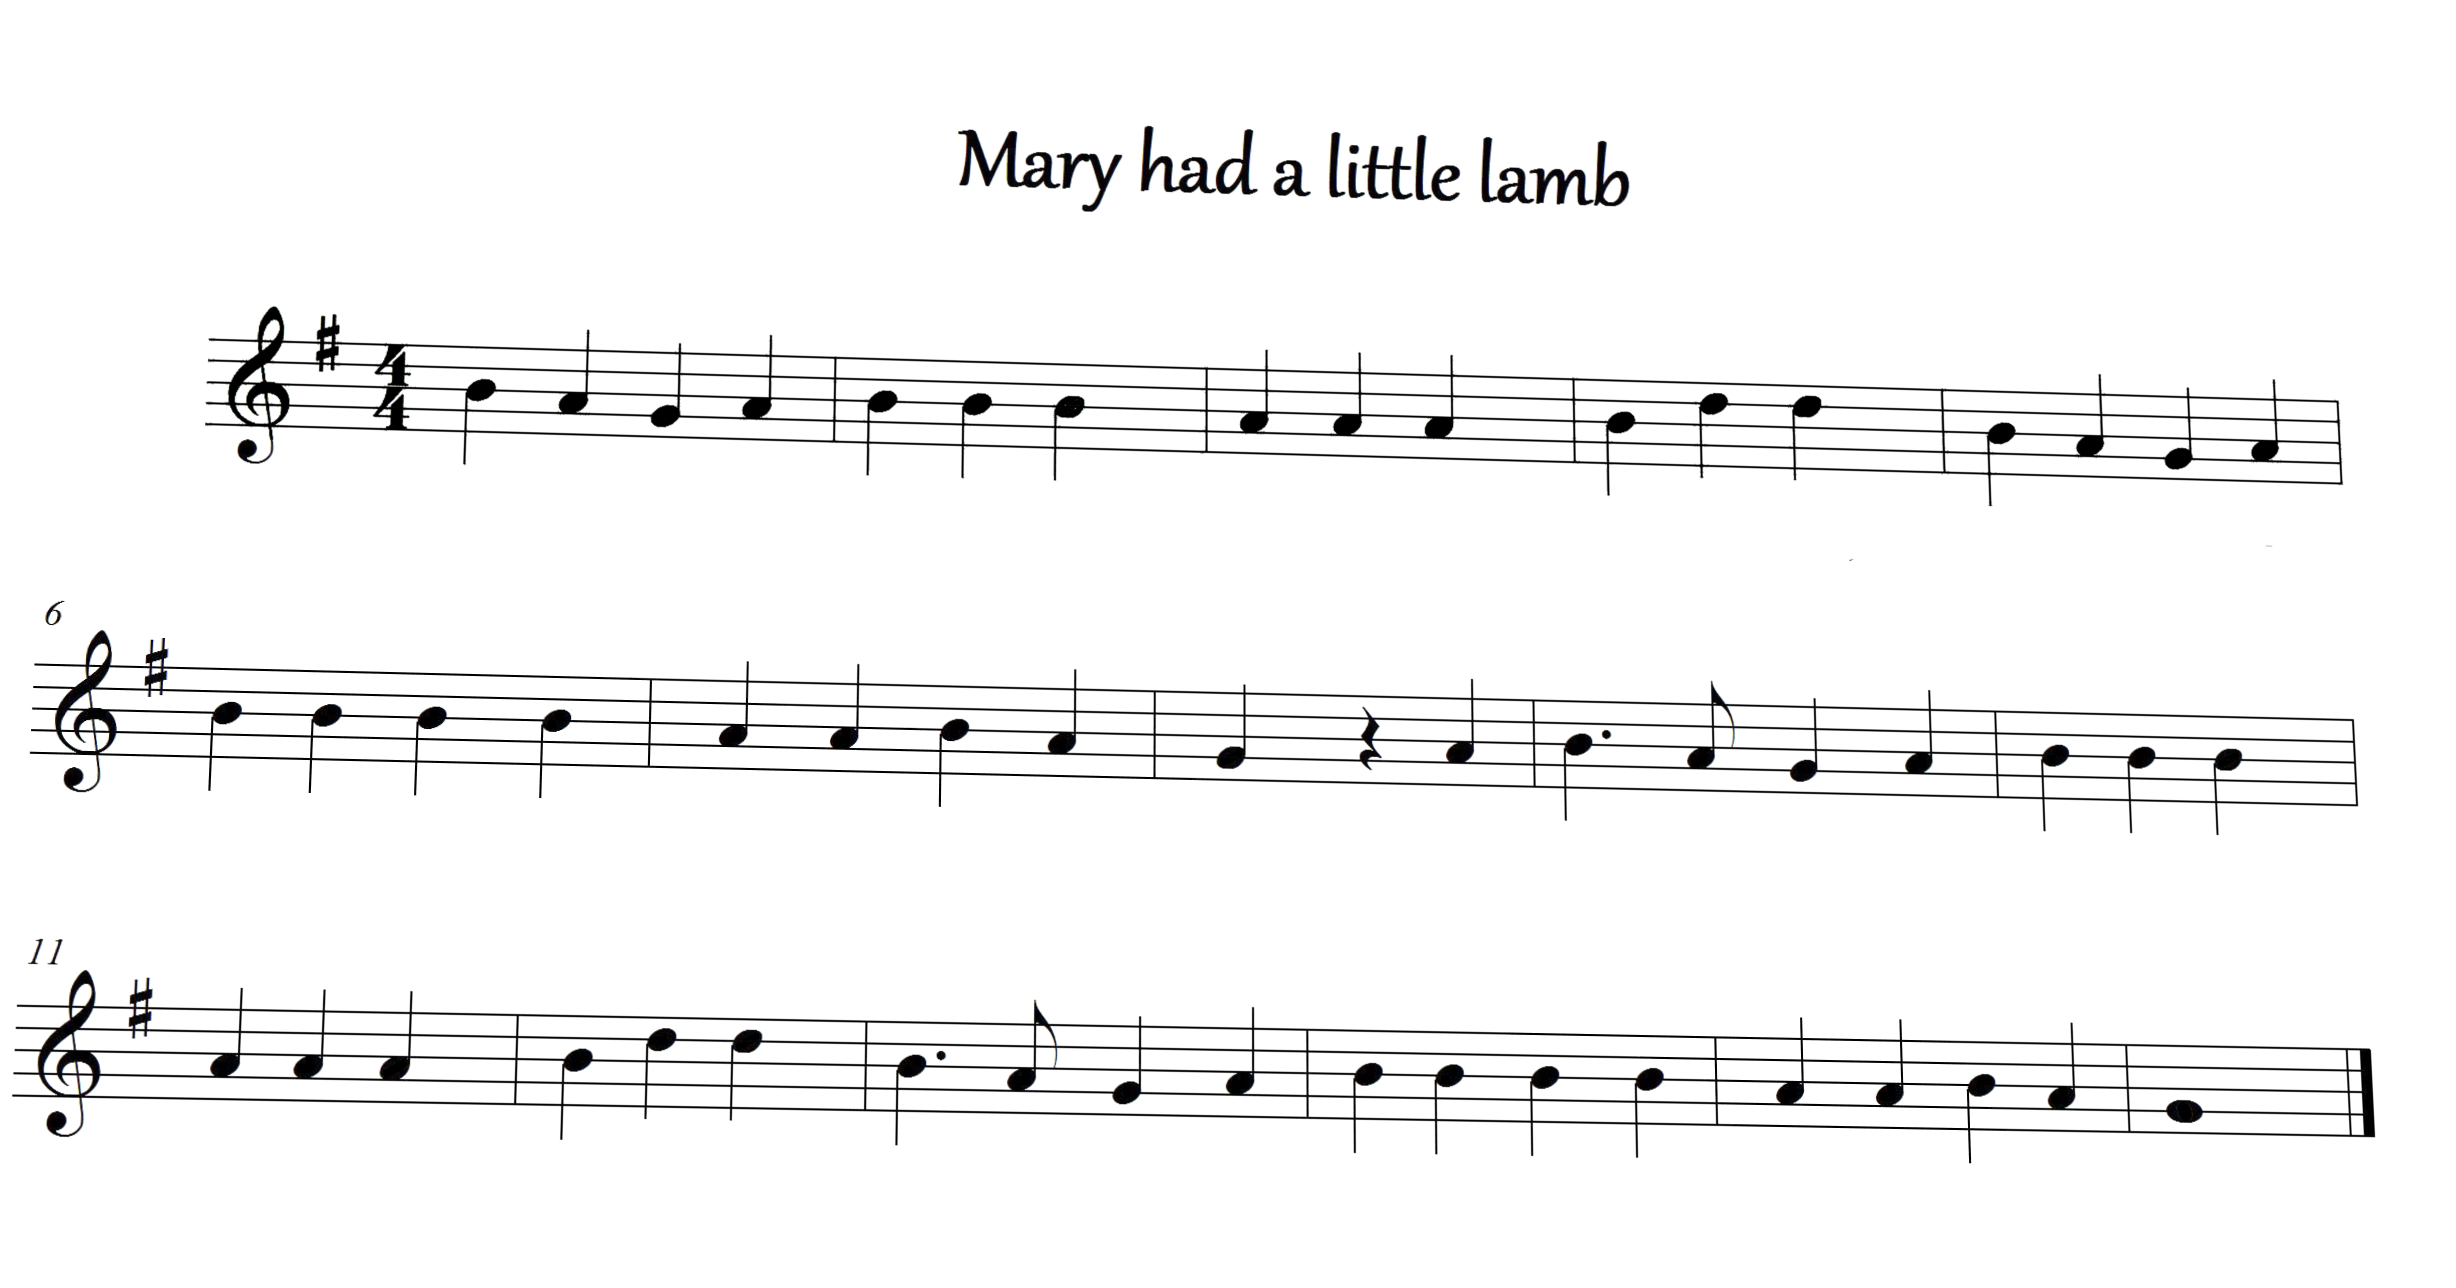

### Rectified Version
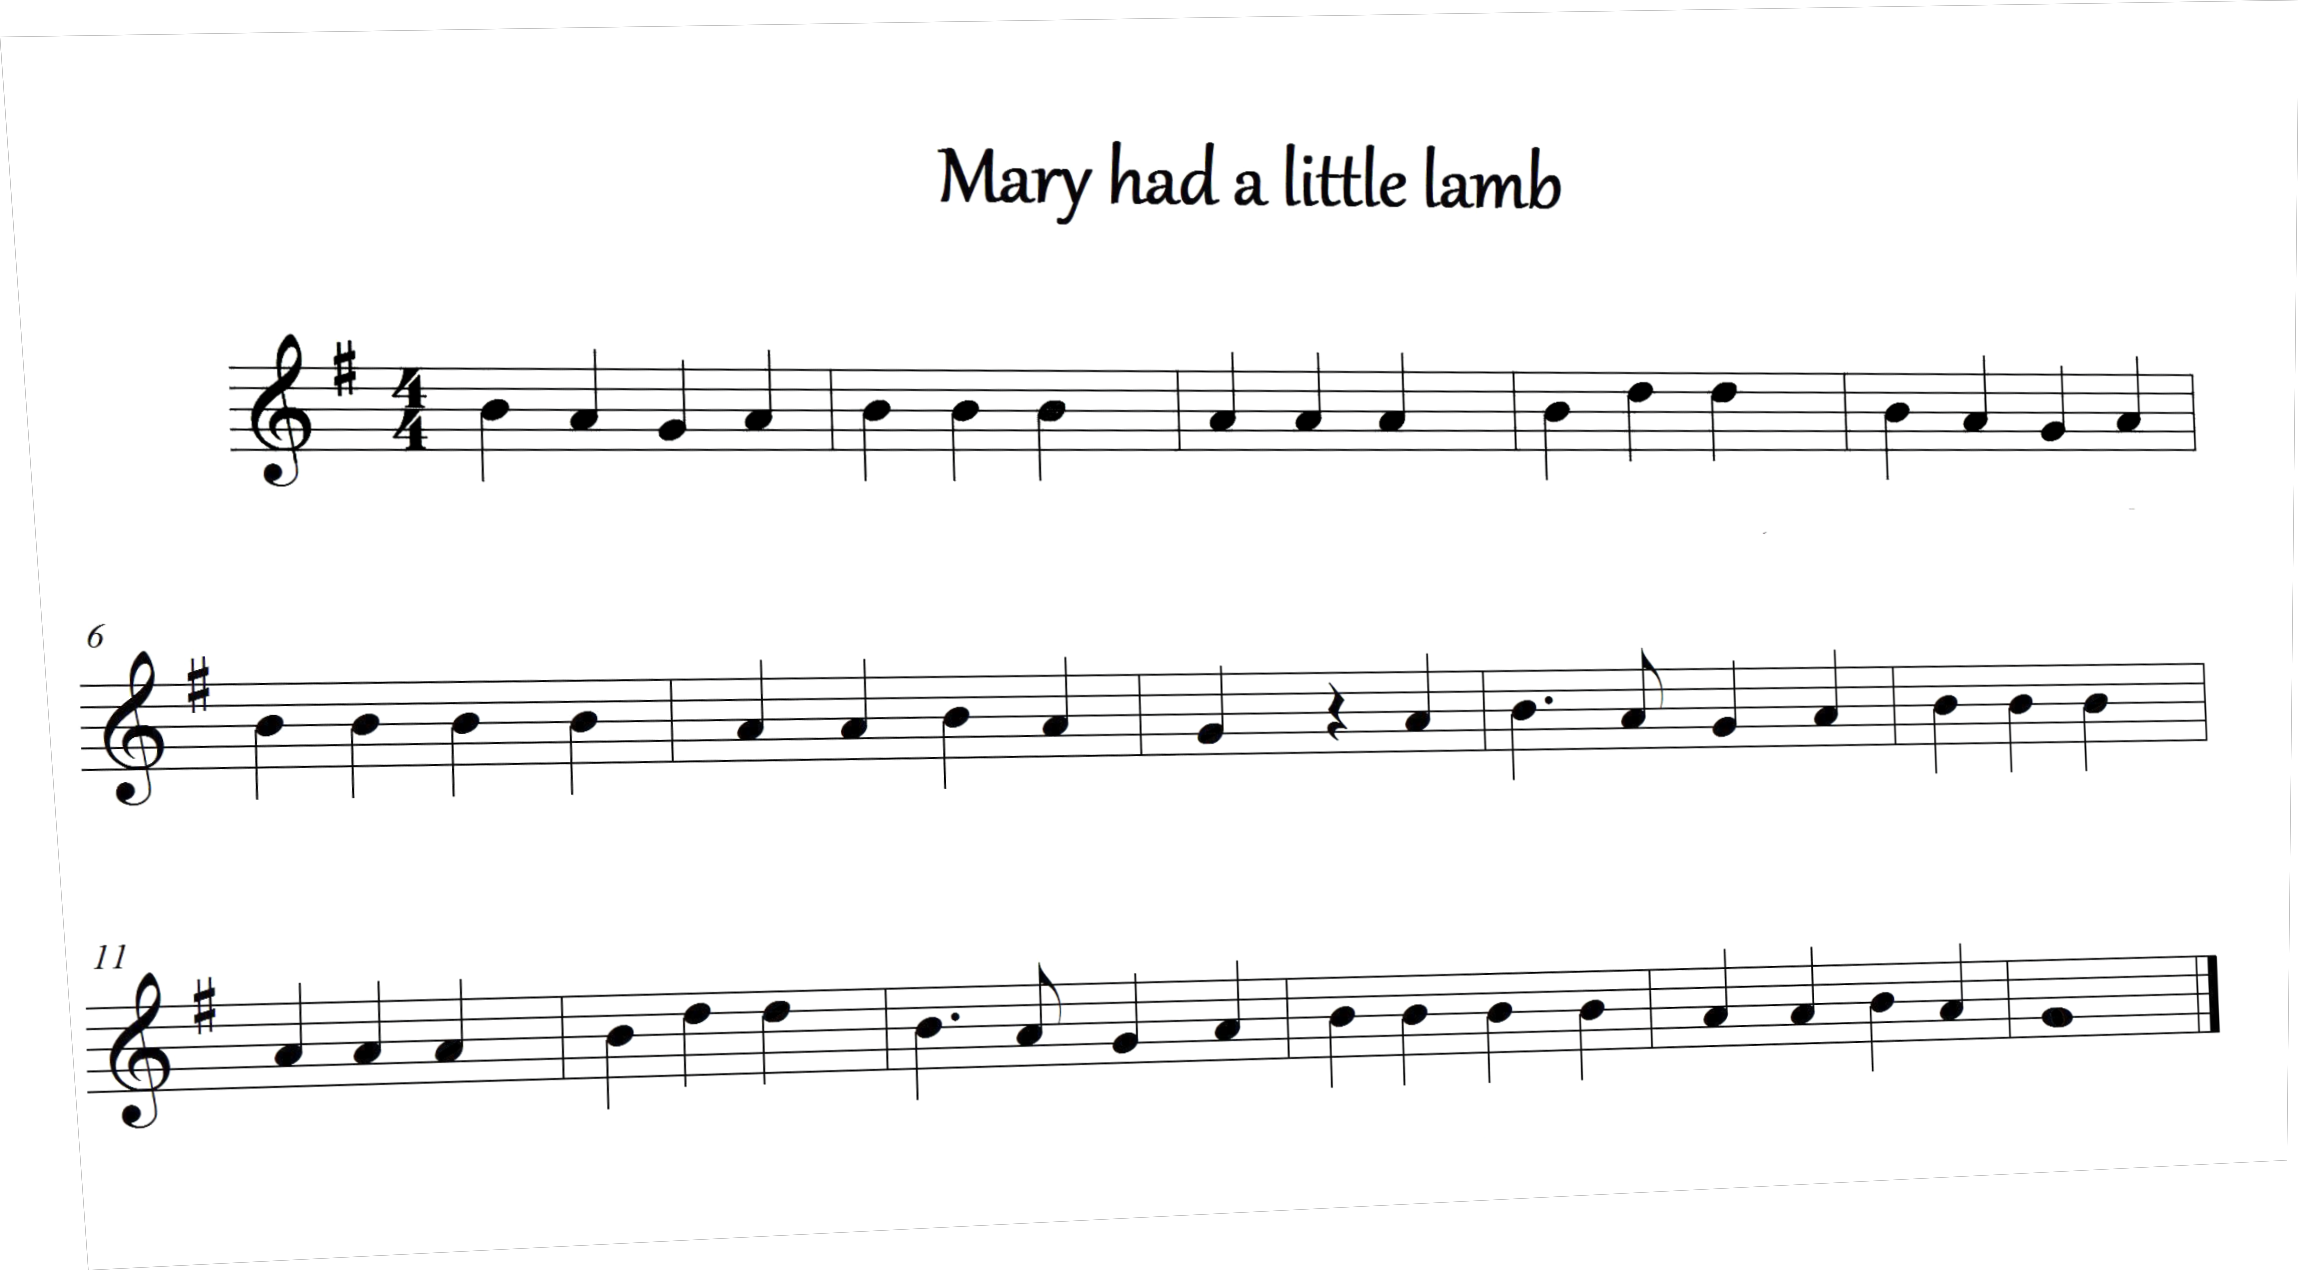

### Determine Line Positions

For every pixel, the same threshold value is applied. If the pixel value is smaller than the threshold, it is set to 0, otherwise it is set to a maximum value. The function cv.threshold is used to apply the thresholding. The first argument is the source image, which should be a grayscale image. The second argument is the threshold value which is used to classify the pixel values. The third argument is the maximum value which is assigned to pixel values exceeding the threshold.

We are using <b>ADAPTIVE_THRESH_MEAN_C</b> which the threshold value $T(x,y)$ is a mean of the $blockSize×blockSize$ neighborhood of $(x,y)$ minus C

For horizontal kernel, we are using rectangle kernel which its size is 40x1

After determining the horizontal kernel, we are using Opening as a morphological transformation which is a same terminology with erosion followed by dilation. We set iterations as 2.

We OpenCV's findContours() function to get contours. We chose the <b>RETR_EXTERNAL</b> as the Contour Retrieval Mode to eliminate unrelevant points which can be effect calculation in the negative way. Furthermore, we chose <b>CHAIN_APPROX_NONE</b> the contour drawing parameter to get all points instead of getting end lines to get more accurate solution

## Output of Line Positions


### Determine Note Positions

We applied Morphologic process to extract note positions from the sheet. In morphology process, we convert picture to greyscale to implement erosion and dilatation process. 

Erosion is a mathematical morphology operation that uses a structuring element for shrinking the shapes in an image. The binary erosion of an image by a structuring element is the locus of the points where a superimposition of the structuring element centered on the point is entirely contained in the set of non-zero elements of the image. 

We set erosion iteration as 2 to prevent losing important features. After that, we applied the dilation process. 

Dilation is typically applied to binary images, but there are versions that work on grayscale images. The basic effect of the operator on a binary image is to gradually enlarge the boundaries of regions of foreground pixels (i.e. white pixels, typically). Thus areas of foreground pixels grow in size while holes within those regions become smaller. We set iteration as 5 to prevent the effect of bigger than usual in calculation step

## Output of Note Positions
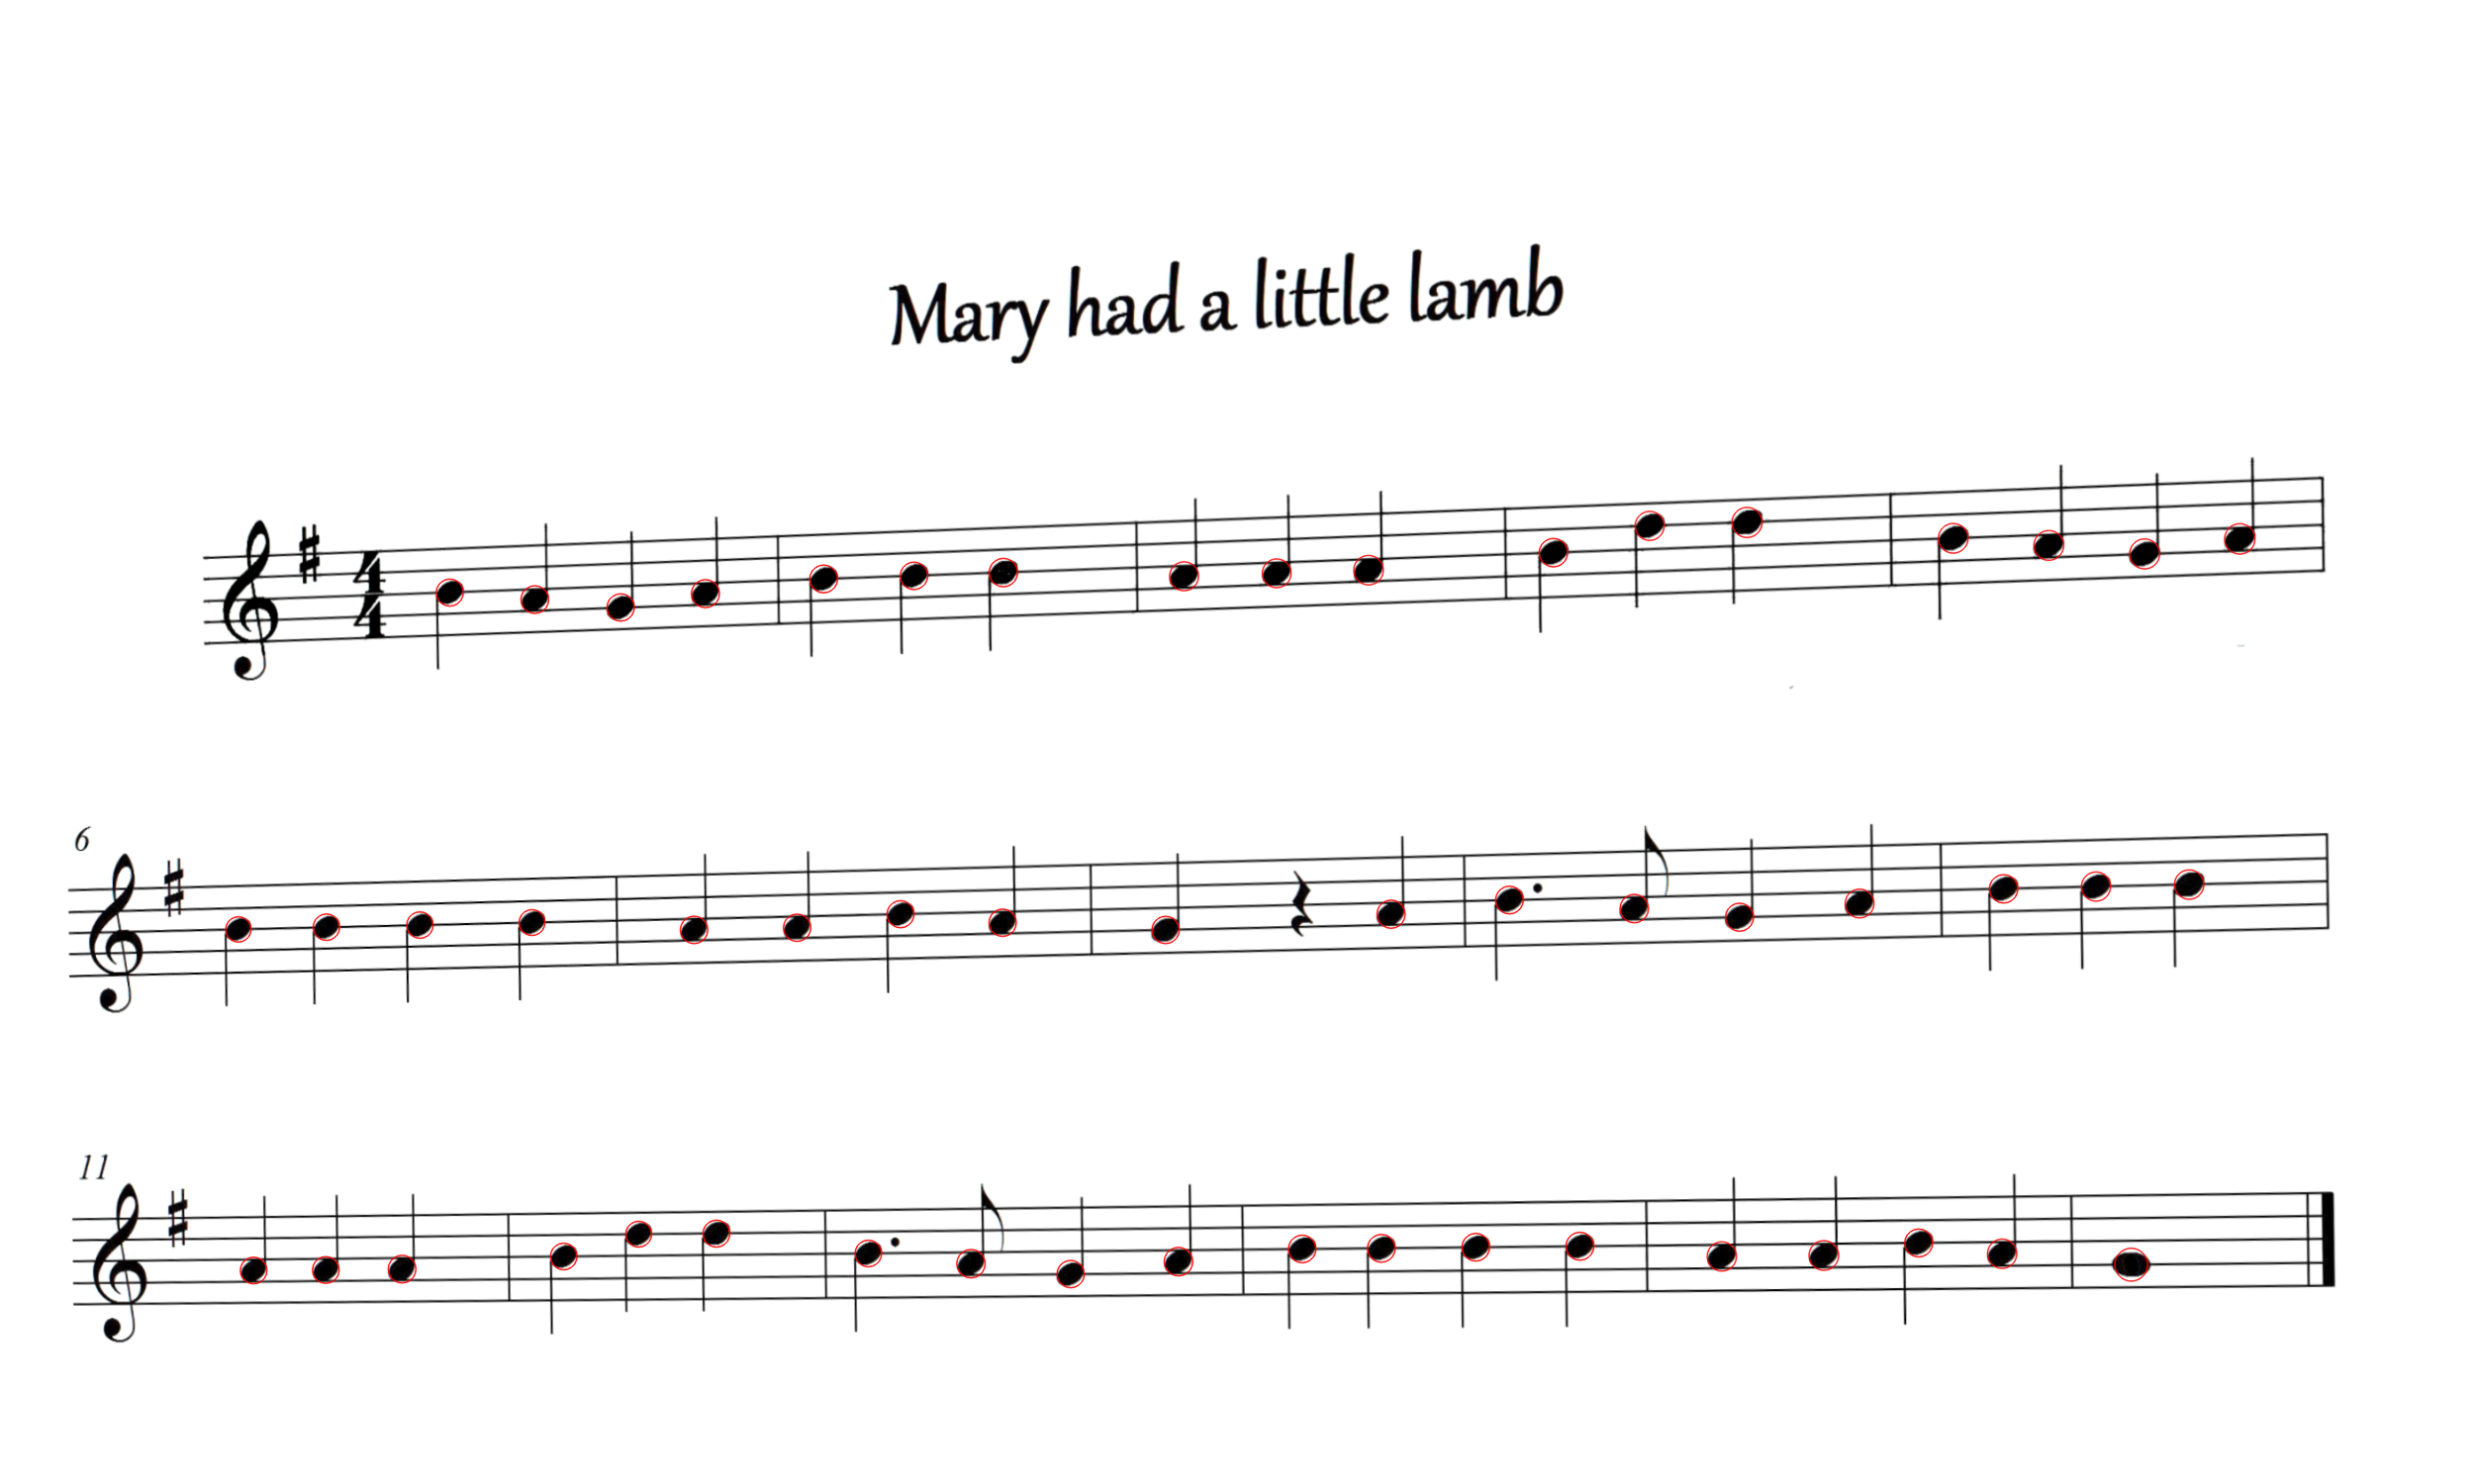

## Get Nearest Point 

We are getting line points which is the most close point to note ellipse. To prevent selecting multiple lines we are eliminating points which is close to threshold value which is set to 10


## Note Determination Table

| Classification | Formula  |
| :- | -: |
| C1 | $line5_{y}$ + ${threshold_{min}}$
| D1 | ($line5_{y}$ + $line5_{y}$ + ${threshold_{min}}$) $/2$
| E1 | $line5_{y}$ 
| F1 | ($line5_{y}$ + $line4_{y}$) $/2$ 
| G1 | $line4_{y}$ 
| A1 | ($line4_{y}$ + $line3_{y}$) $/2$ 
| B2 | $line3_{y}$ 
| C2 | ($line3_{y}$ + $line2_{y}$) $/2$ 
| D2 | $line2_{y}$ 
| E2 | ($line2_{y}$ + $line1_{y}$) $/2$  
| F2 | $line1_{y}$ 
| G2 | ($line1_{y}$ + $line1_{y}$ - ${threshold_{min}}$) $/2$
| A2 | $line1_{y}$ + ${threshold_{min}}$

## Expected Output

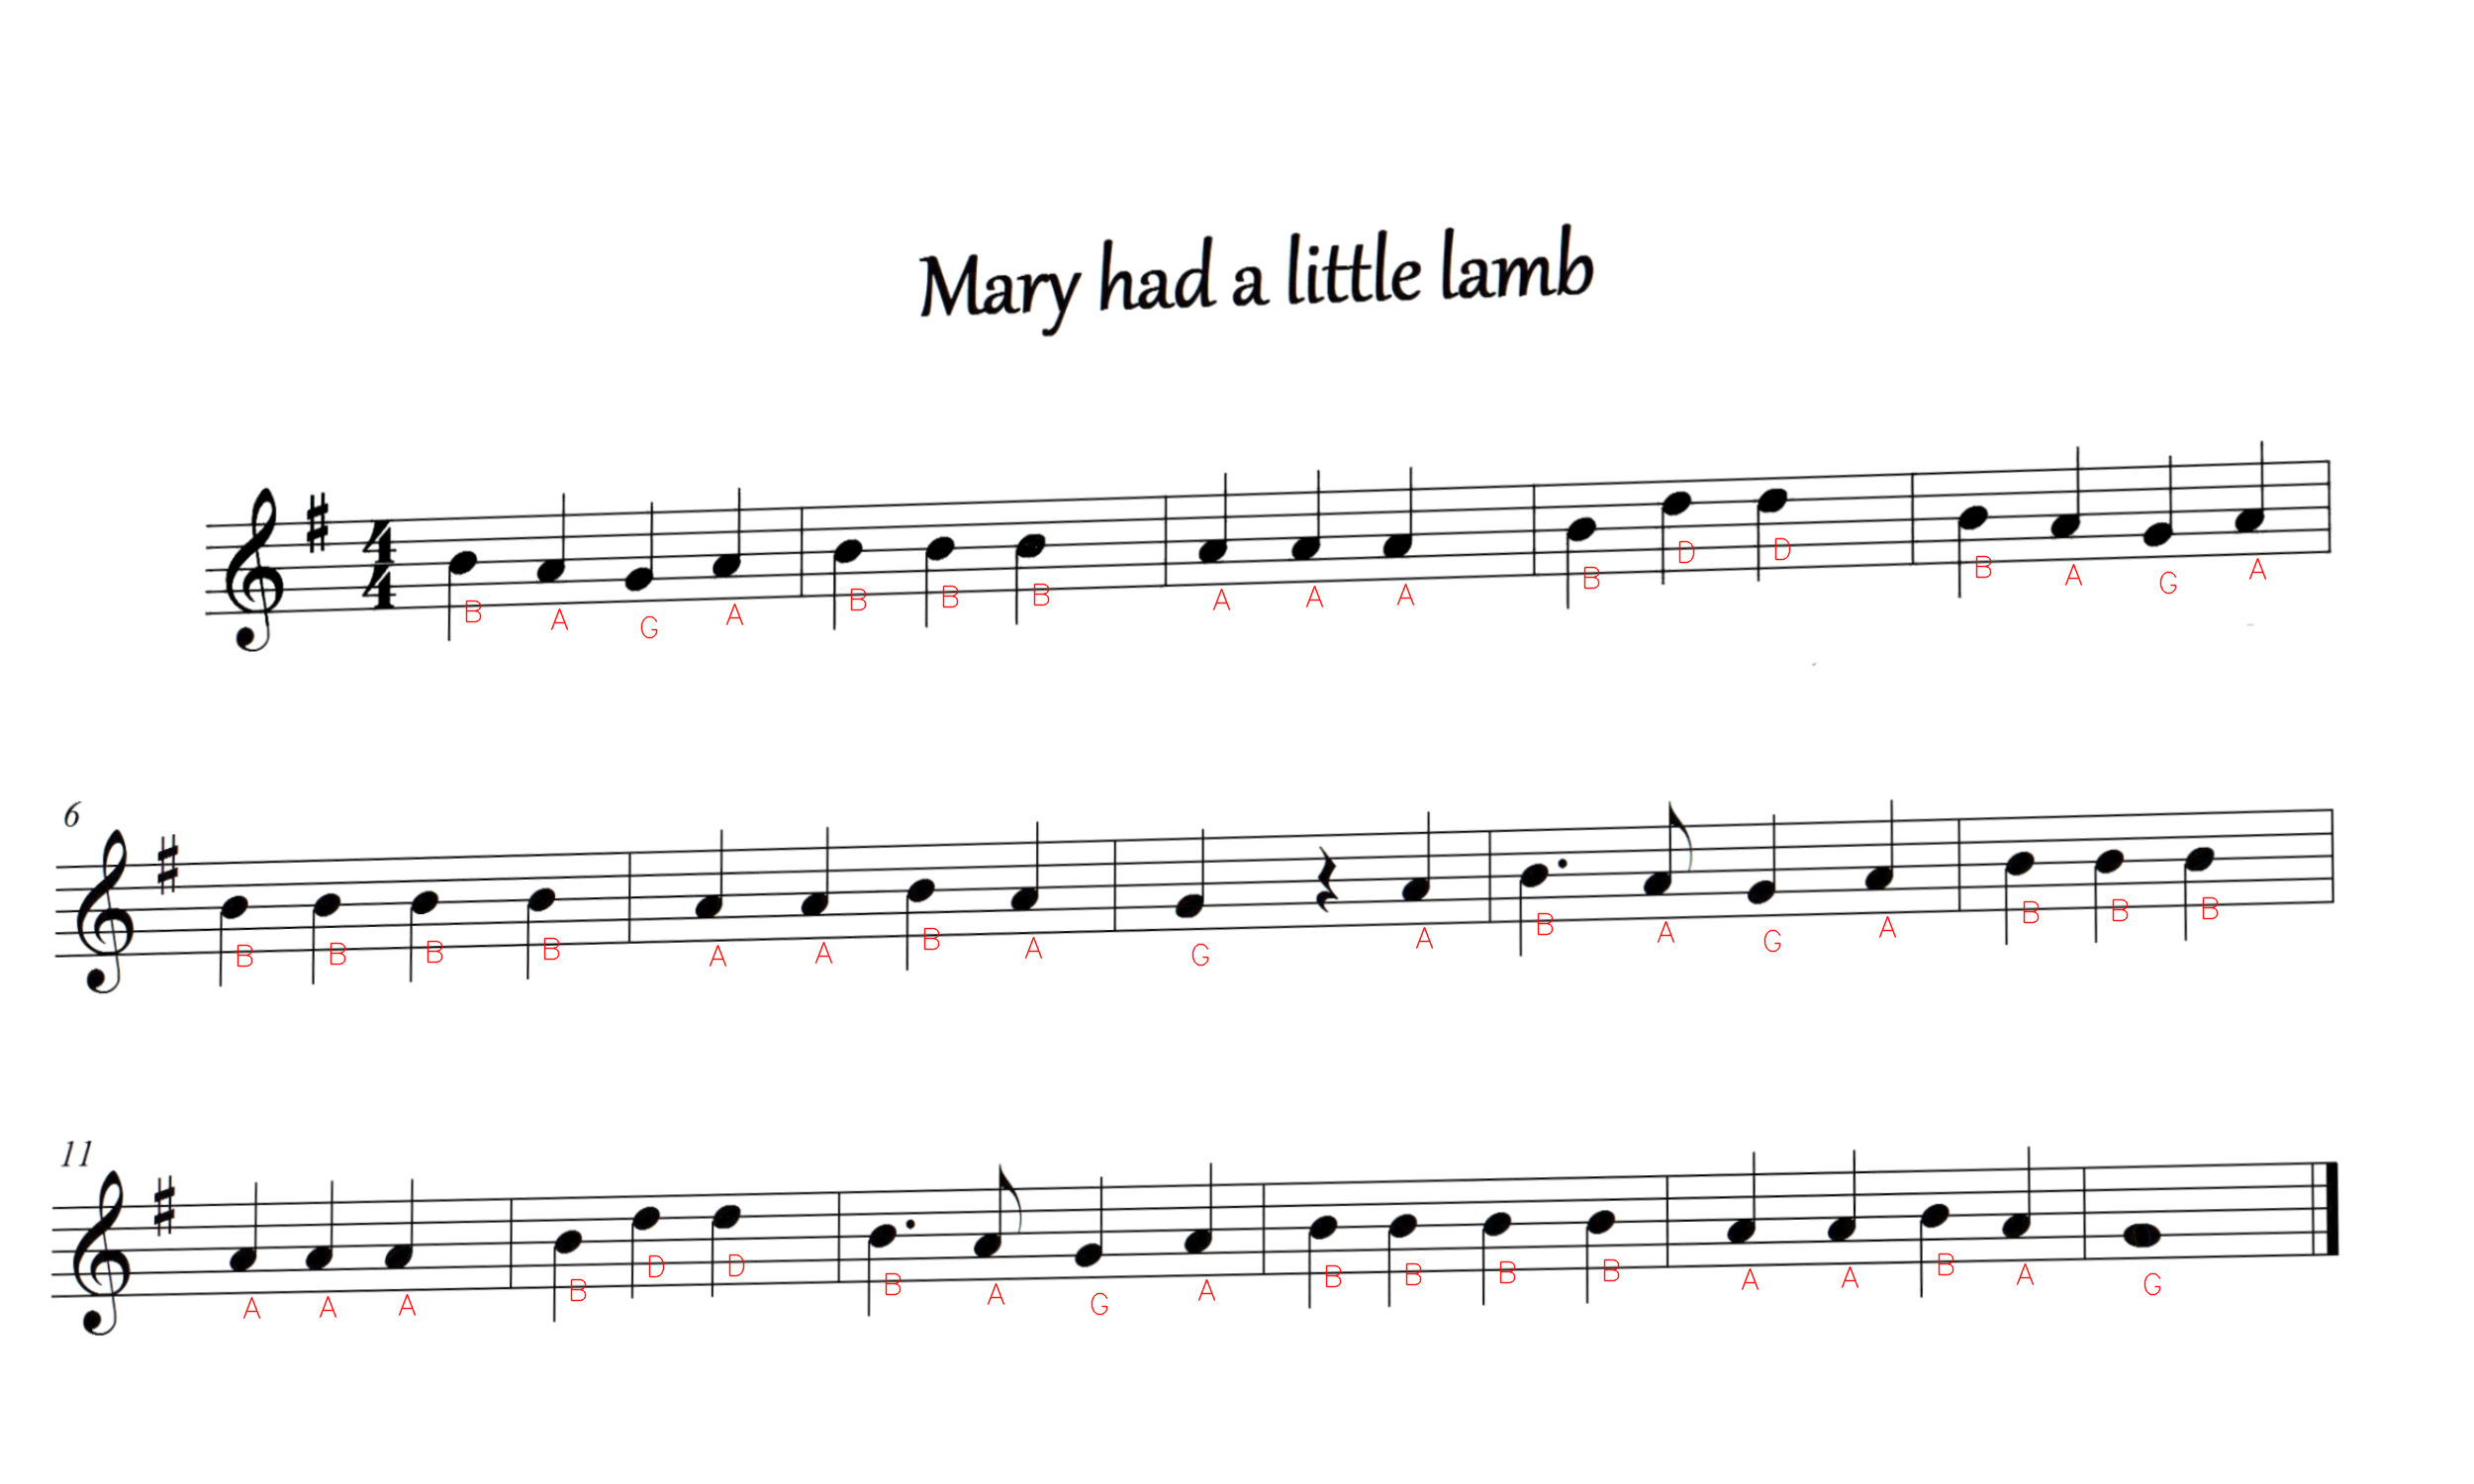

## Accuracy Table

| Image | Accuracy  | Duration
| :- | -: | -: |
| sample.png | %100 | 101.6 sec
| sample2.png | %100 | 116.2 sec
| sample3.png | %100 | 78.4 sec
| sample4.png | %100 | 67.7 sec

In [1]:
from rectification import *
from normalizer import *
from horizontal import *
from ellipse import *
import cv2
import warnings
import random
import os
import time

In [2]:
def find_line_coords(lines, note,image_name):
    min_list = []
    # for line in lines:
    #     minimin = min(line, key=lambda x: abs(x.item(0) - note[0]))
    #     min_list.append(minimin)
    min_lines = []
    image = cv2.imread(image_name)
    for line in lines:
        for point in line:
            min_list.append(point)
            image = draw_circle(image, (int(point.item(0)), int(point.item(1))))
    #cv2.imwrite("Output/converted.png", image)
    sheet_size = 5
    while len(min_lines) < sheet_size:
        minimum = min(min_list, key=lambda x: abs(x.item(0) - note[0]) + abs(x.item(1) - note[1]))
        min_list = [x for x in min_list if x.item(0) != minimum.item(0) and x.item(1) != minimum.item(1)]
        if not any(abs(t.item(1) - minimum.item(1)) < 10 for t in min_lines):
            min_lines.append(minimum)
    min_lines.sort(key=lambda x: x.item(1))

    return min_lines

def find_key(lines, note, image, image_name):
    min_lines = find_line_coords(lines, note,image_name)

    image, key, value = find_note(image, min_lines, note)

    filename = image_name.split(chr(92))
    filename ="Output"+chr(92)+"Images"+chr(92)+filename[2]
    filename = filename.replace("_normalized","_last")
    cv2.imwrite(filename, image)

    return key, value

def find_note(image, min_lines, note, draw=False):
    # Find the minimum space between lines
    minimum = 25
    for i in range(0, len(min_lines) - 1):
        minimum = min(abs(min_lines[i].item(1) - min_lines[i + 1].item(1)), minimum)

    # for i in range(len(min_lines) - 1):
    #     if abs(min_lines[i].item(1) - min_lines[i + 1].item(1)) > 2 * minimum:

    # Find note symbols by coordinates
    note_dict = {
        "A2": (min_lines[0].item(1) - minimum),
        "G2": (min_lines[0].item(1) + (min_lines[0].item(1) - minimum)) / 2,
        "F2": min_lines[0].item(1),
        "E2": (min_lines[1].item(1) + min_lines[0].item(1)) / 2,
        "D2": min_lines[1].item(1),
        "C2": (min_lines[2].item(1) + min_lines[1].item(1)) / 2,
        "B": min_lines[2].item(1),
        "A1": (min_lines[3].item(1) + min_lines[2].item(1)) / 2,
        "G1": min_lines[3].item(1),
        "F1": (min_lines[4].item(1) + min_lines[3].item(1)) / 2,
        "E1": min_lines[4].item(1),
        "D1": (min_lines[4].item(1) + (min_lines[4].item(1) + minimum)) / 2,
        "C1": min_lines[4].item(1) + minimum
    }

    key, value = min(note_dict.items(), key=lambda kv: abs(kv[1] - note[1]))
    font = cv2.FONT_HERSHEY_SIMPLEX
    image = cv2.putText(image, key[0], (int(note[0]), int(note[1]) + 60), font, 1,
                        (0, 0, 255), 0, cv2.LINE_AA)
    if draw:
        clr = random.randint(0, 255)
        for item in note_dict.items():
            image = cv2.putText(image, item[0], (int(note[0] - 50), int(item[1])), font, .25,
                                (36, 255, 12), 0, cv2.LINE_AA)
            image = draw_circle(image, (int(note[0] - 50), int(item[1])), radius=1, clr=(0, 0, 255))
        # Draw lines found
        for item in min_lines:
            image = draw_circle(image, (int(item.item(0)), int(item.item(1))), clr=(0, clr, clr))

        # Draw note head circle
        image = draw_circle(image, (int(note[0]), int(note[1])), radius=4, clr=(0, 0, 255))

    return image, key, note_dict["B"]


def draw_circle(image, center_coordinates, radius=2, clr=(255, 0, 0)):
    return cv2.circle(image, center_coordinates, radius, clr, 2)

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def process(filename):
    rectified_filename = "Input"+chr(92)+ filename
    rectify(rectified_filename)
    norm_filename = '.'.join(filename.split('.')[:-1]) + '_rectified.png'
    normalized_filename = "Generated"+chr(92)+"Rectified"+chr(92)+ norm_filename
    normalize(normalized_filename)
    horizontal_filename = '.'.join(filename.split('.')[:-1]) + '_normalized.png'
    horizontal_filename = "Generated"+chr(92)+"Normalized"+chr(92)+ horizontal_filename
    line_poses = horizontal_lines(horizontal_filename)
    note_poses = ellipse_detection(horizontal_filename)
    note_poses.sort(key=lambda x: (x[1], x[0]))
    
    image = cv.imread(horizontal_filename)
    values = []
    for note in note_poses:
        key, value = find_key(line_poses, note, image, horizontal_filename)
        values.append([key, value * 10 + note[0]])
        
    values.sort(key=lambda x: x[1])
    
    txtname = "Output"+chr(92)+ filename.replace(".png",".txt") 
    txtfile = open(txtname,"w+") 
    for val in values:
        txtfile.write(val[0][0])
    expected_name = "Expected Outputs"+chr(92)+ filename.replace(".png",".txt") 
    expected_file = open(expected_name,"r") 
    expected_string = expected_file.readline()
    calculated_file = open(txtname,"r") 
    calculated_string = calculated_file.readline()
    difference = sum(1 for a, b in zip(expected_string, calculated_string) if a != b)
    return ((len(expected_string)-difference)/len(expected_string))*100

In [5]:
example_list = os.listdir("Input")
for filename in example_list:
    if filename.endswith('.png'):
        start_time = time.time()
        accutacy = process(filename)
        end_time = time.time()
        print("Accuracy= "+str(accutacy))
        print("Duration= "+str(end_time-start_time))
        print("--------------------------------------")

Rectifying Input\sample.png


Generated\Horizontal\sample_horizontal.png
Accuracy= 100.0
Duration= 101.67605257034302
--------------------------------------
Rectifying Input\sample2.png


Generated\Horizontal\sample2_horizontal.png
Accuracy= 100.0
Duration= 116.23519396781921
--------------------------------------
Rectifying Input\sample3.png


Generated\Horizontal\sample3_horizontal.png
Accuracy= 100.0
Duration= 78.41788697242737
--------------------------------------
Rectifying Input\sample4.png


Generated\Horizontal\sample4_horizontal.png
Accuracy= 100.0
Duration= 67.70539832115173
--------------------------------------
